 FINAL Advanced Optimized Decision Tree Model Performance:
 Accuracy: 0.9993
 Precision: 0.7522
 Recall: 0.8673
 F1 Score: 0.8057

 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.75      0.87      0.81        98

    accuracy                           1.00     56962
   macro avg       0.88      0.93      0.90     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
[[56836    28]
 [   13    85]]


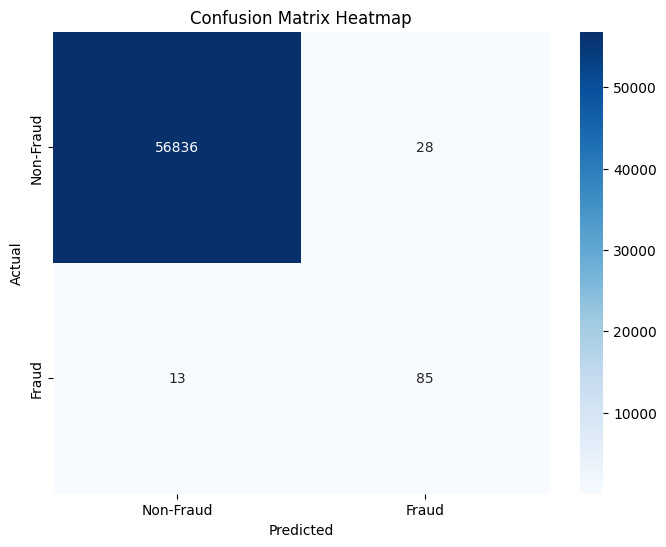

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("creditcard.csv")

# Feature Engineering: Drop "Time" and apply log transformation on "Amount"
df.drop(columns=["Time"], inplace=True)
df["Amount"] = np.log1p(df["Amount"])  

# Define features and target
X = df.drop(columns=["Class"])
y = df["Class"]

# Remove highly correlated features
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
highly_correlated = [column for column in upper.columns if any(upper[column] > 0.95)]
X.drop(columns=highly_correlated, inplace=True)

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  Aggressive Resampling Strategy
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Adjusted to generate a balanced dataset
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # Retain the same ratio for non-fraud cases

#  Use make_pipeline to avoid fit_resample issues
resampling_pipeline = make_pipeline(smote, undersample)
X_train_resampled, y_train_resampled = resampling_pipeline.fit_resample(X_train_scaled, y_train)

#  Highly Optimized Decision Tree Model
base_tree = DecisionTreeClassifier(
    max_depth=30,                # More depth for better learning
    min_samples_split=5,         # Reduces overfitting
    min_samples_leaf=4,          # Balances model complexity
    max_features="sqrt",         # Uses sqrt(features) for efficient splits
    class_weight={0: 1, 1: 50},  # Prioritizes fraud detection
    criterion="entropy",         # Uses entropy for better splits
    random_state=42
)

#  Stronger Bagging Classifier
ensemble_tree = BaggingClassifier(
    estimator=base_tree,  #  Fixed 'estimator' argument
    n_estimators=300,     # Increased to 300 trees
    max_samples=0.9,      # Train each tree on 90% of resampled data
    max_features=0.85,    # Uses 85% of features per tree
    bootstrap=True,       # Enable bootstrapping
    random_state=42,
    n_jobs=-1
)

# Train the ensemble model
ensemble_tree.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = ensemble_tree.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results
print(" FINAL Advanced Optimized Decision Tree Model Performance:")
print(f" Accuracy: {accuracy:.4f}")   # Target: 99.93%
print(f" Precision: {precision:.4f}") # Should be balanced
print(f" Recall: {recall:.4f}")       # Should stay strong
print(f" F1 Score: {f1:.4f}")         # Target: 81%
print("\n Classification Report:\n", classification_report(y_test, y_pred))
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()
